In [2]:
from d2l import torch as d2l 
import torch 
from torch import nn 
import numpy as np 
import math

In [3]:
max_degree = 20 
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.3416],
         [-2.1405]]),
 tensor([[ 1.0000e+00,  1.3416e+00,  8.9994e-01,  4.0245e-01,  1.3498e-01,
           3.6219e-02,  8.0985e-03,  1.5521e-03,  2.6029e-04,  3.8801e-05,
           5.2055e-06,  6.3488e-07,  7.0980e-08,  7.3251e-09,  7.0195e-10,
           6.2783e-11,  5.2643e-12,  4.1545e-13,  3.0965e-14,  2.1864e-15],
         [ 1.0000e+00, -2.1405e+00,  2.2909e+00, -1.6346e+00,  8.7474e-01,
          -3.7448e-01,  1.3360e-01, -4.0853e-02,  1.0931e-02, -2.5998e-03,
           5.5649e-04, -1.0829e-04,  1.9317e-05, -3.1806e-06,  4.8630e-07,
          -6.9396e-08,  9.2841e-09, -1.1690e-09,  1.3901e-10, -1.5661e-11]]),
 tensor([  5.9449, -14.5945]))

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0018106  1.1757829 -3.4068706  5.644597 ]]


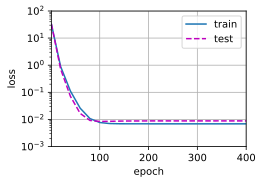

In [8]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.8335516 4.6076818]]


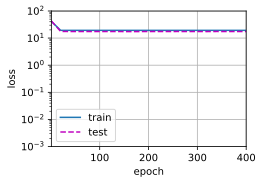

In [9]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0009747   1.2711942  -3.382798    5.253257   -0.20876013  0.7659904
   0.6072523  -0.08069263  0.18253201  0.141473    0.09023513  0.01198346
   0.146044   -0.05712271  0.20905846 -0.07921889  0.05181917  0.20298047
  -0.17793548 -0.15923326]]


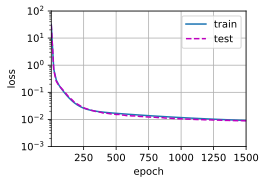

In [10]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)